# Pacotes

In [74]:
from google.cloud import bigquery # conexão banco de dados
from google.oauth2 import service_account # conexão banco de dados
from pandas.io import gbq # conexão banco de dados

import pandas as pd  # biblioteca para trabalhar com dataframes e realizar ETL
import numpy as np  # biblioteca para trabalhar com arrays
import statsmodels.api as sm  # biblioteca para explorar, estimar e testar dados e modelos estatísticos 
import matplotlib.pyplot as plt  #biblioteca para criar gráficos "comuns" ao estilo Matlab.
from datetime import date, timedelta, datetime  # biblioteca para trabalhar com datas
from dateutil.relativedelta import relativedelta  # biblioteca de extensão do datetime
from scipy import stats  # biblioteca de computação científica

from pandas import DataFrame 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression  # Regressão Logit do sklearn
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Load Dataset

In [75]:
# Credenciais Google Cloud

credentials = service_account.Credentials.from_service_account_file(filename='/home/alex/apps/crendentials/ContaServicoBigQuery.json', 
                                                                    scopes=["https://www.googleapis.com/auth/cloud-platform"])
client = bigquery.Client(credentials=credentials)
# Query SQL
sql = """
SELECT
  CASE
    WHEN ra.nota < 4 THEN "Negativo"
    WHEN ra.nota  >= 7 THEN "Positivo"
    END AS sentimento,
  ra.tempo_reclamacao,
  ra.status,
  REGEXP_CONTAINS(ra.titulo, r'Seguro|seguro|Seguros|seguros|Sinistro|sinistro|Sinitros|sinistros|Carro|carro|Carros|Carro|Proteção|proteção|Proteções|proteções|Atendimento|atendimento|Atendimentos|atendimentos') AS token_positivo,
  REGEXP_CONTAINS(ra.titulo, r'Seguro|seguro|Seguros|seguros|Prestamista|prestamista|Prestamistas|prestamistas|Sinistro|sinistro|Sinitros|sinistros|Cancelamento|cancelamento|Cancelamentos|cancelamento|Reembolso|reembolso|Reembolsos|reembolsos') AS token_negativo
FROM `braided-upgrade-355410.ReclameAquiStage.reclamacoes` as ra
WHERE ra.nota > 7 OR ra.nota < 4 
"""


In [76]:
# carrega dataset
dataset = client.query(sql).to_dataframe()

In [77]:
# copy

df = dataset.copy()

In [78]:
# verificando o dataset

df.head()

,sentimento,tempo_reclamacao,status,token_positivo,token_negativo
0,Negativo,4,Não resolvido,False,False
1,Negativo,13,Não resolvido,False,True
2,Negativo,15,Não resolvido,True,True
3,Negativo,15,Não resolvido,False,False
4,Negativo,16,Resolvido,False,False


In [79]:
print('Amostras e Features', df.shape)
print('Columns: ', df.dtypes)

Amostras e Features (1418, 5)
Columns:  sentimento           object
tempo_reclamacao      Int64
status               object
token_positivo      boolean
token_negativo      boolean
dtype: object


## Removendo Outliers

In [80]:
#verificando se existem outliers (anomalias) usando o boxblot

boxplot = df.boxplot(column=['tempo_reclamacao'])

In [81]:
def remove_outliers(columns: list, qtd_desvios: int, df: DataFrame) -> DataFrame:
    
    for column in columns:
        
        quartil_01 = df[column].quantile(q=0.25)
        quartil_03 = df[column].quantile(q=0.75)
        amplitude = quartil_03 - quartil_01
        
        print(f'''
        Coluna: {column}
        Tamanho Inicial: {df.shape[0]}
        ''')
        
        # df = df.loc[~df.index.isin(list(result[0]))]
        
        df = df.loc[
            (df[column] > (quartil_01 - 1.5 * amplitude)) &
            (df[column] < (quartil_03 + 1.5 * amplitude))
        ]
        
        print(f'''
        Tamanho Final: {df.shape[0]}
        ##########################################
        ''')
        
    return df

In [82]:
df2 = remove_outliers(['tempo_reclamacao'], 1, df)


        Coluna: tempo_reclamacao
        Tamanho Inicial: 1418
        

        Tamanho Final: 1379
        ##########################################
        


## Dummies

Para a transformão iremos utilizar dois metódos:

dummy: transformar uma variavel categorica com valores 0 e 1.

combinação de recursos: na combinação de recursos pegaremos duas variavies categóricas semelhante e combinaremos em uma única variável.


In [83]:
df3 = df2.copy()

In [84]:
df3['sentimento'].replace({'Positivo':'1',
                            'Negativo':'0'},inplace=True)

In [85]:
df3.groupby(by=['sentimento']).count()

,tempo_reclamacao,status,token_positivo,token_negativo
sentimento,,,,
0,967,967,967,967
1,412,412,412,412


In [86]:
df3['sentimento'] = df3['sentimento'].astype(int)

In [87]:
df3['dummy_positive'] = df3.groupby(['status','token_positivo'], sort=False).ngroup()

In [88]:
df3['dummy_negative'] = df3.groupby(['status','token_negativo'], sort=False).ngroup()

In [89]:
df3.drop(columns=['status','token_positivo','token_negativo'],inplace=True)

In [90]:
df3.groupby(by=['dummy_positive','dummy_negative']).count()

sentimento  tempo_reclamacao
dummy_positive dummy_negative                              
0              0                      404               404
               1                       31                31
1              0                       61                61
               1                      183               183
2              2                      417               417
               3                       58                58
3              2                       47                47
               3                      178               178

In [91]:
df3.head()

,sentimento,tempo_reclamacao,dummy_positive,dummy_negative
0,0,4,0,0
1,0,13,0,1
2,0,15,1,1
3,0,15,0,0
4,0,16,2,2


## Seleção de Recursos

In [1]:
from sklearn.feature_selection import SequentialFeatureSelector
#Selecting the Best important features according to Logistic Regression
sfs_selector = SequentialFeatureSelector(estimator=LogisticRegression(), n_features_to_select = 3, cv =10, direction ='backward')
sfs_selector.fit(X, y)
X.columns[sfs_selector.get_support()]

NameError: name 'LogisticRegression' is not defined

## Analisando a multicolinearidade

In [92]:
df3.dtypes

sentimento          int64
tempo_reclamacao    Int64
dummy_positive      int64
dummy_negative      int64
dtype: object

In [93]:
# verificando multicolinearidade
# VIF 
vif_df = pd.DataFrame() 
vif_df['var'] = df3.columns

# Calculando o VIF para cada variável

vif_df["VIF"] = [variance_inflation_factor(np.array(df3.values, dtype=float), i) 
                          for i in range(len(df3.columns))] 

print(vif_df)

                var        VIF
0        sentimento   2.198230
1  tempo_reclamacao   1.628588
2    dummy_positive  21.923026
3    dummy_negative  22.372720


In [94]:
# removendo variaveis com VIF maior que 10
df4 = df3.drop(columns='dummy_positive')

In [95]:
df4.head()

,sentimento,tempo_reclamacao,dummy_negative
0,0,4,0
1,0,13,1
2,0,15,1
3,0,15,0
4,0,16,2


In [96]:
df4.dtypes

sentimento          int64
tempo_reclamacao    Int64
dummy_negative      int64
dtype: object

## Splitting the dataset into the Training set and Test set

In [97]:
# separando os dados em treino e teste
X = df4.loc[:, df4.columns != 'sentimento']
y = df4.loc[:, df4.columns == 'sentimento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# salvando as variaveis xn
columns = X_train.columns

In [98]:
X_train = X_train.astype(int, errors='ignore')

In [99]:
X_train

,tempo_reclamacao,dummy_negative
611,17,1
447,43,0
964,58,1
338,4,2
1401,44,2
...,...,...
789,21,3
861,38,3
1248,18,3
575,42,0


In [100]:
y_train =  y_train.astype(int, errors='ignore')

## Feature Scaling - Padronização de Valores

Utilizamos a padronização de valores quando temos valores muitos descrepetantes. Desta forma, os valores são transformados em um intervalo de -3 a 3.

*Obs*: caso os valores já estiveram no intervalo de -3 a 3 não será necessário padronizalos.

In [101]:
dados_num = X_train.loc[:,['tempo_reclamacao']]
scraler = StandardScaler()
X_train['tempo_reclamacao'] = StandardScaler().fit_transform(dados_num)

In [102]:
X_train.head()

,tempo_reclamacao,dummy_negative
611,-0.188394,1
447,1.536665,0
964,2.531891,1
338,-1.050923,2
1401,1.603013,2


## Balanceamento

In [103]:
# Aplicando o metodo SMOTE
os = SMOTE(random_state=0)

# modelando em cima dos dados de treino
os_data_X,os_data_y= os.fit_resample(X_train, y_train)

In [142]:
print("Tamanho da Amostra final: ",len(os_data_X))
print("Quantidade de sentimentos negativos", len(os_data_y[os_data_y['sentimento']==0]))
print("Quantidade de sentimentos positivos", len(os_data_y[os_data_y['sentimento']==1]))
print("Proporcao de sentimentos negativos",len(os_data_y[os_data_y['sentimento']==0])/len(os_data_X))
print("Proporcao de sentimentos positivos",len(os_data_y[os_data_y['sentimento']==1])/len(os_data_X))

Tamanho da Amostra final:  1408
Quantidade de sentimentos negativos 704
Quantidade de sentimentos positivos 704
Proporcao de sentimentos negativos 0.5
Proporcao de sentimentos positivos 0.5


# Train

## Regressao Logit

In [105]:
# setando as variaveis dependentes
X=os_data_X[columns];

# setando a variavel resposta
y=os_data_y['sentimento'];

In [106]:
# aplicando o modelo nos dados de treino

logit_model = sm.Logit(y,X)

# treinando o modelo

result = logit_model.fit()

# Printando os resultados

print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.620610
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.105     
Dependent Variable: sentimento       AIC:              1751.6376 
Date:               2022-12-13 23:44 BIC:              1762.1374 
No. Observations:   1408             Log-Likelihood:   -873.82   
Df Model:           1                LL-Null:          -975.95   
Df Residuals:       1406             LLR p-value:      2.4501e-46
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
tempo_reclamacao  -0.1916   0.0568 -3.3756 0.0007 -0.3028 -0.0803
dummy_negative     0.3998   0.0310 12.8954 0.0000  0.3391  0.4606


In [107]:
# Aplicando o modelo usando o sklearn

logreg = LogisticRegression(random_state=0)
logreg.fit(X, y)

LogisticRegression(random_state=0)

In [ ]:
y_pred = logreg.predict(X_test)

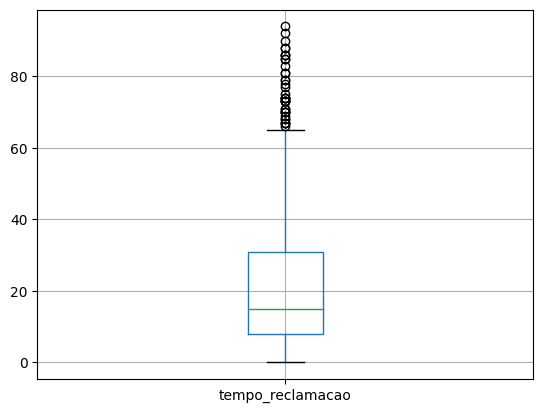

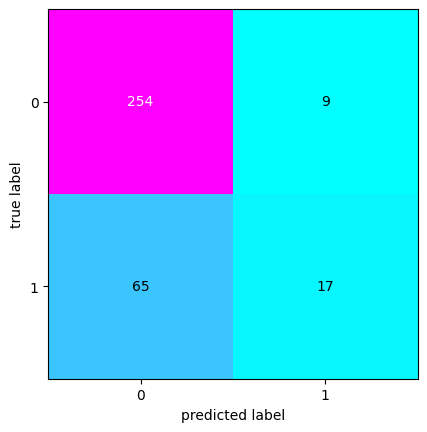

In [109]:
matriz_confusao = confusion_matrix(y_test, y_pred)

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao, cmap='cool')
plt.show()

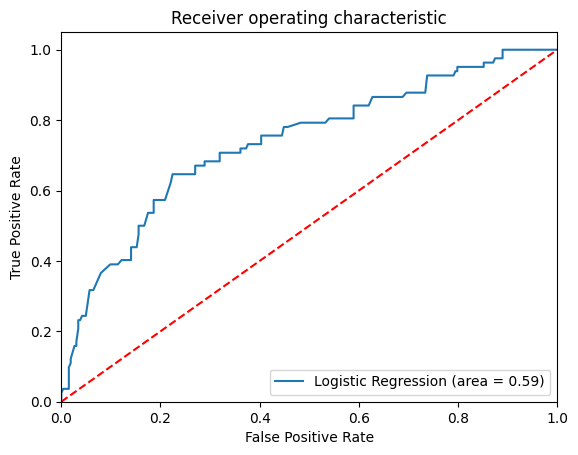

In [110]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [111]:
print('\nPrecision\n', metrics.precision_score(y_test, y_pred)) 
print('\nRecall\n', metrics.recall_score(y_test, y_pred)) 
print('\nF1\n', metrics.f1_score(y_test, y_pred)) 
print('\nAUCROC\n', metrics.roc_auc_score(y_test, y_pred))


Precision
 0.6538461538461539

Recall
 0.2073170731707317

F1
 0.3148148148148148

AUCROC
 0.58654827042567


## Naive Bayes


In [ ]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

/home/alex/.virtualenvs/reclameaqui/lib/python3.11/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [ ]:
y_pred = classifier.predict(X_test)
print('Accuracy of random forest regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

Accuracy of random forest regression classifier on test set: 0.77


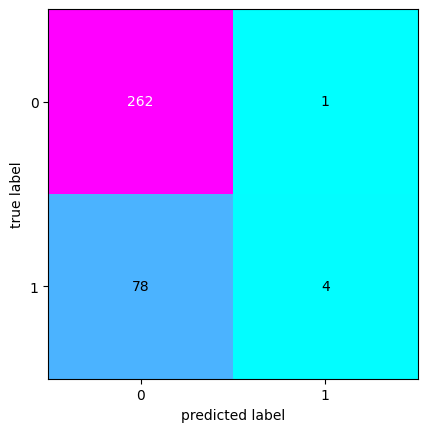

In [ ]:
matriz_confusao = confusion_matrix(y_test, y_pred)

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao, cmap='cool')
plt.show()

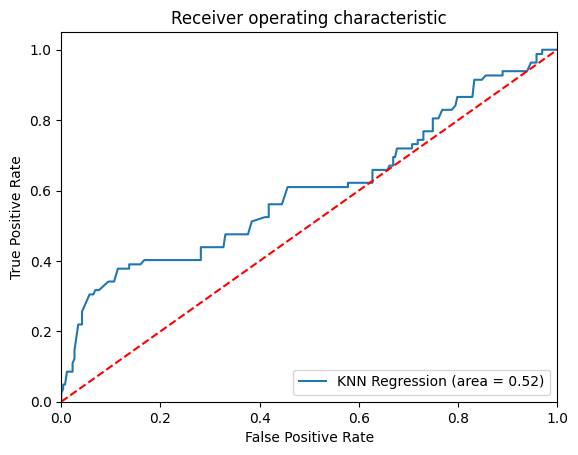

In [ ]:
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='KNN Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print('\nPrecision\n', metrics.precision_score(y_test, y_pred)) 
print('\nRecall\n', metrics.recall_score(y_test, y_pred)) 
print('\nF1\n', metrics.f1_score(y_test, y_pred)) 
print('\nAUCROC\n', metrics.roc_auc_score(y_test, y_pred))


Precision
 0.8

Recall
 0.04878048780487805

F1
 0.09195402298850576

AUCROC
 0.5224891032180284


## SVM

In [122]:
from sklearn.svm import SVC
svmreg = SVC(kernel='rbf',probability=True)
svmreg.fit(X, y);

In [123]:
y_pred = svmreg.predict(X_test)
print('Accuracy of random forest regression classifier on test set: {:.2f}'.format(svmreg.score(X_test, y_test)))

Accuracy of random forest regression classifier on test set: 0.78


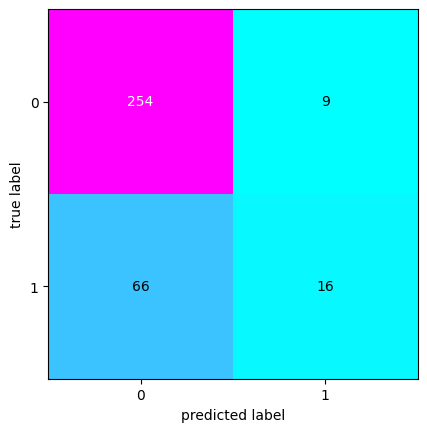

In [124]:
matriz_confusao = confusion_matrix(y_test, y_pred)

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao, cmap='cool')
plt.show()

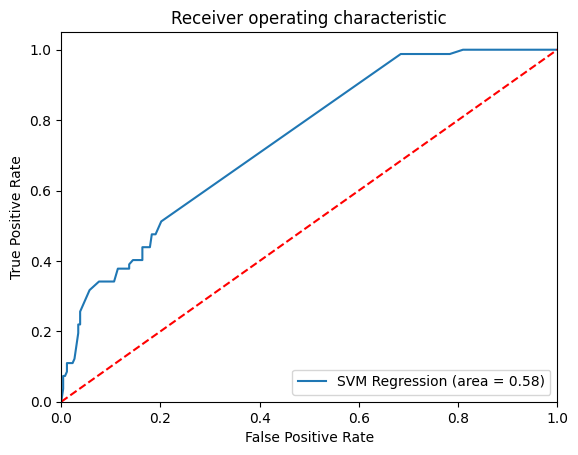

In [125]:
logit_roc_auc = roc_auc_score(y_test, svmreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, svmreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [126]:
print('\nPrecision\n', metrics.precision_score(y_test, y_pred)) 
print('\nRecall\n', metrics.recall_score(y_test, y_pred)) 
print('\nF1\n', metrics.f1_score(y_test, y_pred)) 
print('\nAUCROC\n', metrics.roc_auc_score(y_test, y_pred))


Precision
 0.64

Recall
 0.1951219512195122

F1
 0.2990654205607477

AUCROC
 0.5804507094500603


## KNN

In [ ]:
# Aplicando o modelo usando o sklearn
from sklearn.neighbors import KNeighborsClassifier

knnreg = KNeighborsClassifier();
knnreg.fit(X, y);

In [ ]:
y_pred = knnreg.predict(X_test)
print('Accuracy of knn regression classifier on test set: {:.2f}'.format(knnreg.score(X_test, y_test)))

Accuracy of knn regression classifier on test set: 0.78


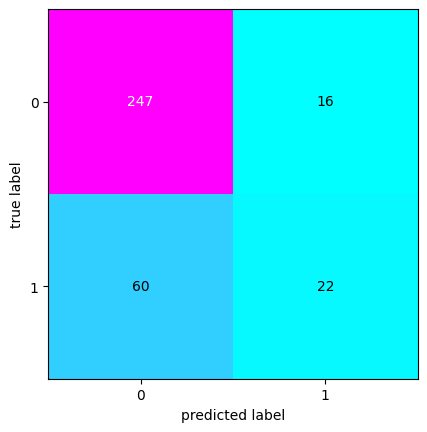

In [ ]:
matriz_confusao = confusion_matrix(y_test, y_pred)

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao, cmap='cool')
plt.show()

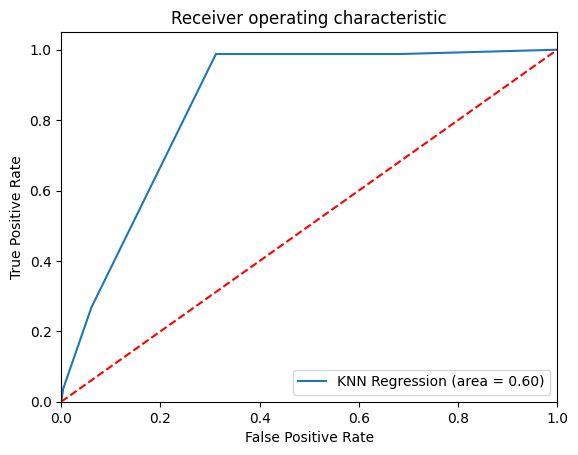

In [ ]:
logit_roc_auc = roc_auc_score(y_test, knnreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, knnreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='KNN Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print('\nPrecision\n', metrics.precision_score(y_test, y_pred)) 
print('\nRecall\n', metrics.recall_score(y_test, y_pred)) 
print('\nF1\n', metrics.f1_score(y_test, y_pred)) 
print('\nAUCROC\n', metrics.roc_auc_score(y_test, y_pred))


Precision
 0.5789473684210527

Recall
 0.2682926829268293

F1
 0.36666666666666664

AUCROC
 0.6037280905128443


## Random Forest Classifiers


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfreg = RandomForestClassifier(n_estimators= 10, random_state=42)
rfreg.fit(X, y);

In [ ]:
y_pred = rfreg.predict(X_test)
print('Accuracy of random forest regression classifier on test set: {:.4f}'.format(rfreg.score(X_test, y_test)))

Accuracy of random forest regression classifier on test set: 0.7449


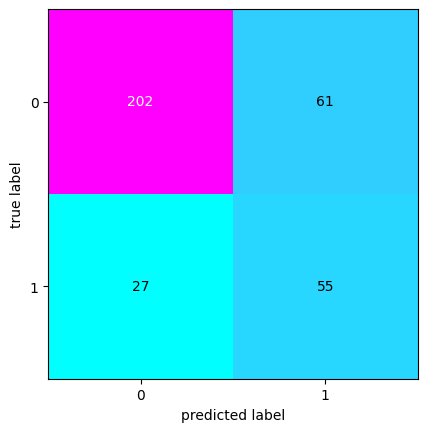

In [ ]:
matriz_confusao = confusion_matrix(y_test, y_pred)

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao, cmap='cool')
plt.show()

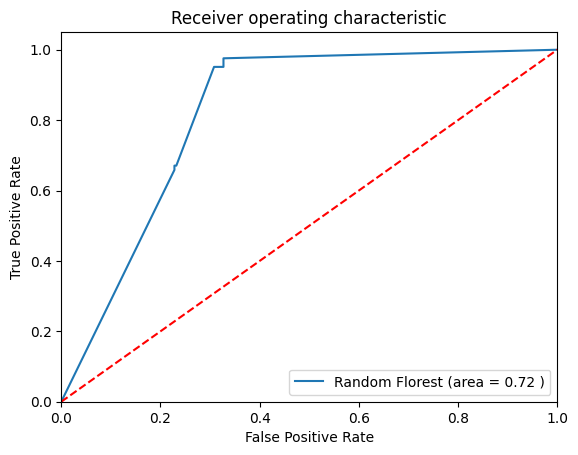

In [ ]:
logit_roc_auc = roc_auc_score(y_test, rfreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Florest (area = %0.2f )' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print('\nPrecision\n', metrics.precision_score(y_test, y_pred)) 
print('\nRecall\n', metrics.recall_score(y_test, y_pred)) 
print('\nF1\n', metrics.f1_score(y_test, y_pred)) 
print('\nAUCROC\n', metrics.roc_auc_score(y_test, y_pred))


Precision
 0.47413793103448276

Recall
 0.6707317073170732

F1
 0.5555555555555556

AUCROC
 0.7193962719094873


## Decision Tree Classifiers


In [137]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [138]:
y_pred = classifier.predict(X_test)
print('Accuracy of random forest regression classifier on test set: {:.4f}'.format(classifier.score(X_test, y_test)))

Accuracy of random forest regression classifier on test set: 0.7536


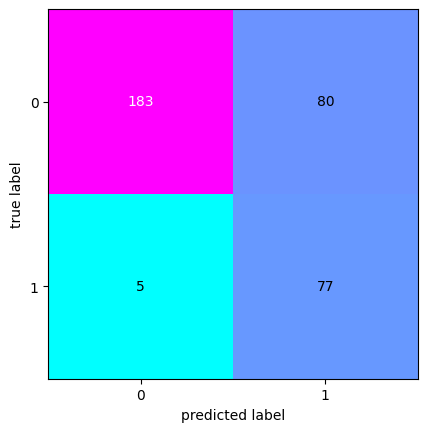

In [139]:
matriz_confusao = confusion_matrix(y_test, y_pred)

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao, cmap='cool')
plt.show()

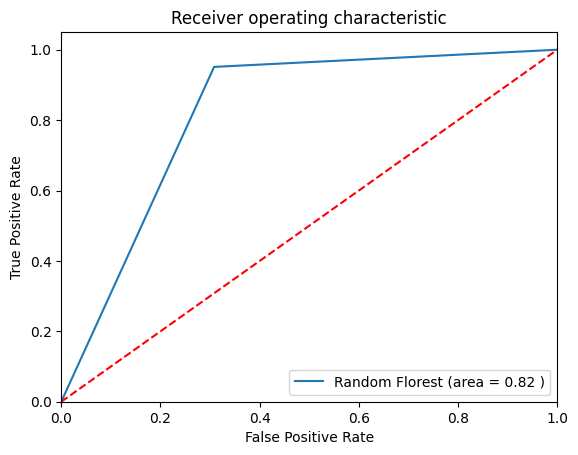

In [140]:
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Florest (area = %0.2f )' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [141]:
print('\nPrecision\n', metrics.precision_score(y_test, y_pred)) 
print('\nRecall\n', metrics.recall_score(y_test, y_pred)) 
print('\nF1\n', metrics.f1_score(y_test, y_pred)) 
print('\nAUCROC\n', metrics.roc_auc_score(y_test, y_pred))


Precision
 0.49044585987261147

Recall
 0.9390243902439024

F1
 0.6443514644351463

AUCROC
 0.8174209403690995


## XGBOOST


In [132]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [133]:
y_pred = classifier.predict(X_test)
print('Accuracy of random forest regression classifier on test set: {:.4f}'.format(classifier.score(X_test, y_test)))

Accuracy of random forest regression classifier on test set: 0.7478


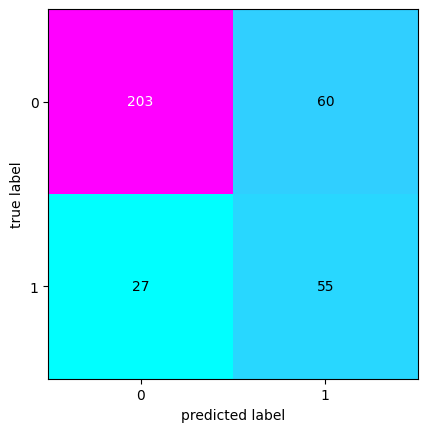

In [134]:
matriz_confusao = confusion_matrix(y_test, y_pred)

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao, cmap='cool')
plt.show()

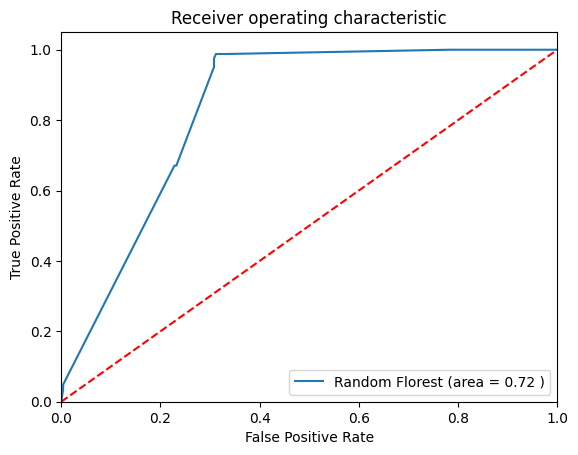

In [135]:
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Florest (area = %0.2f )' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [136]:
print('\nPrecision\n', metrics.precision_score(y_test, y_pred)) 
print('\nRecall\n', metrics.recall_score(y_test, y_pred)) 
print('\nF1\n', metrics.f1_score(y_test, y_pred)) 
print('\nAUCROC\n', metrics.roc_auc_score(y_test, y_pred))


Precision
 0.4782608695652174

Recall
 0.6707317073170732

F1
 0.5583756345177665

AUCROC
 0.7212974125938979
